In [1]:

import math

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor

from src.DataManager import DataManager
from src.config import UTK_PATH, UTK_METADATA_FILENAME
from src.models.HandcraftedModel import HandcraftedModel
from src.models.Model import IMAGE_INPUT_SIZE


In [2]:
N_SAMPLE = 0.1

# Read the data
data_manager = DataManager(UTK_PATH, UTK_METADATA_FILENAME, IMAGE_INPUT_SIZE,
                           n_subset=N_SAMPLE, normalize_images=True, normalize_age=True)
data = data_manager.get_dataset()

In [3]:
data.describe(include='all')

,age,gender,full_path,path
count,962.000000,962.000000,962,962
unique,NaN,NaN,962,962
top,NaN,NaN,crop_part1/53_0_2_20170104210010763.jpg.chip.jpg,../dataset/utk\crop_part1/53_0_2_2017010421001...
freq,NaN,NaN,1,1
mean,0.283910,0.566528,NaN,NaN
std,0.244663,0.495812,NaN,NaN
min,0.000000,0.000000,NaN,NaN
25%,0.060606,0.000000,NaN,NaN
50%,0.242424,1.000000,NaN,NaN
75%,0.484848,1.000000,NaN,NaN


In [4]:
# Split into train, validation, test
train, validation, test = data_manager.split_dataset(data)
# Read images
print('Read training images ...')
X_train, y_train = data_manager.get_X(train), data_manager.get_y(train)
print('Read validation images ...')
X_val, y_val = data_manager.get_X(validation), data_manager.get_y(validation)
print('Read test images ...')
X_test, y_test = data_manager.get_X(test), data_manager.get_y(test)

Read training images ...


100%|██████████| 572/572 [00:01<00:00, 569.99it/s]


Read validation images ...


100%|██████████| 101/101 [00:00<00:00, 640.43it/s]


Read test images ...


100%|██████████| 289/289 [00:00<00:00, 630.72it/s]


In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(572, 224, 224, 3)
(572, 2)
(101, 224, 224, 3)
(101, 2)
(289, 224, 224, 3)
(289, 2)


In [6]:
n_sift = 50
color_hist_bins = 128
lbp_n_points = 24
lbp_radius = 3
compute_sift = False
compute_hog = False
compute_hist = True
compute_lbp = False
handcrafted_model = HandcraftedModel(n_sift, color_hist_bins, lbp_n_points, lbp_radius)

# EXTRACTIONS
df_train = handcrafted_model.extract_dataset_features(X_train, y_train, compute_sift, compute_hog, compute_hist,
                                                      compute_lbp)
df_val = handcrafted_model.extract_dataset_features(X_val, y_val, compute_sift, compute_hog, compute_hist, compute_lbp)
df_test = handcrafted_model.extract_dataset_features(X_test, y_test, compute_sift, compute_hog, compute_hist,
                                                     compute_lbp)

# CLEANING FROM NANS
data_manager.delete_nan_columns(df_train, df_val, df_test)

Extracting dataset features ...


100%|██████████| 572/572 [00:16<00:00, 35.28it/s]


Extracting dataset features ...


100%|██████████| 101/101 [00:03<00:00, 30.70it/s]


Extracting dataset features ...


100%|██████████| 289/289 [00:08<00:00, 33.88it/s]


Deleted a maximum of 0 columns


In [7]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(572, 1538)
(101, 1538)
(289, 1538)


In [8]:
clf = SVC()
clf.fit(df_train.drop(columns=["age", "gender"], axis=1), df_train["gender"])

SVC()

In [9]:
preds = clf.predict(df_test.drop(columns=["age", "gender"], axis=1))
acc_test = accuracy_score(df_test["gender"], preds)
conf_mat_test = confusion_matrix(df_test["gender"], preds)
print(acc_test)
print(conf_mat_test)

0.5432525951557093
[[  0 132]
 [  0 157]]


In [10]:
preds = clf.predict(df_val.drop(columns=["age", "gender"], axis=1))
acc_val = accuracy_score(df_val["gender"], preds)
conf_mat_val = confusion_matrix(df_val["gender"], preds)
print(acc_val)
print(conf_mat_val)

0.6435643564356436
[[ 0 36]
 [ 0 65]]


In [11]:
classifier = KNeighborsClassifier(n_neighbors=3, algorithm='brute')
classifier.fit(df_train.drop(columns=["age", "gender"], axis=1), df_train["gender"])
preds = classifier.predict(df_test.drop(columns=["age", "gender"], axis=1))
acc_test = accuracy_score(df_test["gender"], preds)
conf_mat_test = confusion_matrix(df_test["gender"], preds)
print(acc_test)
print(conf_mat_test)

0.5432525951557093
[[  0 132]
 [  0 157]]


In [22]:
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(df_train.drop(columns=["age", "gender"], axis=1), df_train["age"])

DecisionTreeRegressor(random_state=0)

Mean squared error: 614.1690831490478
Root mean squared error: 24.782434972154125
Mean absolute error: 20.564352602414893


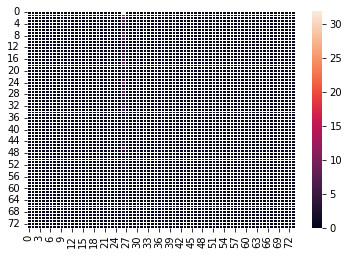

In [34]:
scaler = data_manager.get_scaler()

preds_test = regressor.predict(df_test.drop(columns=["age", "gender"], axis=1))
age_test = data_manager.inverse_standardize_age([df_test["age"]])[0]
age_preds_test = data_manager.inverse_standardize_age([preds_test])[0]

print('Mean squared error: ' + str(mean_squared_error(age_test, age_preds_test)))
print('Root mean squared error: ' + str(math.sqrt(mean_squared_error(age_test, age_preds_test))))
print('Mean absolute error: ' + str(mean_absolute_error(age_test, age_preds_test)))

age_test = [math.floor(a) for a in age_test]
age_preds_test = [math.floor(a) for a in age_preds_test]

conf_mat_test = confusion_matrix(age_test, age_preds_test)

sns.heatmap(conf_mat_test, linewidth=0.5)
plt.show()

Mean squared error: 604.9772353243926
Root mean squared error: 24.59628499030682
Mean absolute error: 20.77975489856678


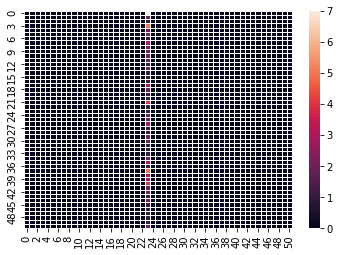

In [35]:
preds_val = regressor.predict(df_val.drop(columns=["age", "gender"], axis=1))
age_val = data_manager.inverse_standardize_age([df_val["age"]])[0]
age_preds_val = data_manager.inverse_standardize_age([preds_val])[0]

print('Mean squared error: ' + str(mean_squared_error(age_val, age_preds_val)))
print('Root mean squared error: ' + str(math.sqrt(mean_squared_error(age_val, age_preds_val))))
print('Mean absolute error: ' + str(mean_absolute_error(age_val, age_preds_val)))

age_val = [math.floor(a) for a in age_val]
age_preds_val = [math.floor(a) for a in age_preds_val]

conf_mat_val = confusion_matrix(age_val, age_preds_val)

sns.heatmap(conf_mat_val, linewidth=0.5)
plt.show()

array([[34., 46., 25.,  2., 40., 29., 82., 18., 29., 25.,  1., 10.,  9.,
        26., 13., 67.,  9.,  5., 52.,  1.,  5., 16., 37., 17., 21., 66.,
        95., 15., 90., 60.,  1., 18., 37.,  6.,  1.,  1., 25., 24.,  1.,
        21., 24., 67., 32., 41.,  2., 26.,  1.,  3.,  3., 39.,  3., 52.,
        53., 52.,  1., 37., 15., 52.,  4., 43., 65., 61., 53., 17.,  2.,
         2., 80., 15., 10.,  9., 55., 53.,  9., 35., 41., 64., 77., 35.,
        28., 23.,  7., 57.,  8., 32., 36., 36., 72., 45., 36., 69., 31.,
        60., 30., 85., 82., 12., 18., 23.,  1., 10., 22.,  1., 27., 20.,
        54.,  1.,  1., 55., 66., 14., 47., 14.,  5.,  2.,  8., 88.,  4.,
        37.,  1., 37.,  3.,  3., 65., 36.,  4., 32., 49.,  9., 30., 49.,
         8., 22., 26., 63.,  1., 13., 16., 17., 60., 26., 80.,  1., 49.,
        75., 85., 80.,  1., 14., 59.,  1., 16.,  1.,  1.,  1.,  3., 26.,
        26., 60.,  1., 18., 43., 38.,  1.,  8., 14., 45., 17., 20.,  1.,
         1., 22., 43., 31.,  8., 31., 18., 30.,  3.